In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import tensorflow as tf 
from tensorflow.keras import Sequential, utils, layers

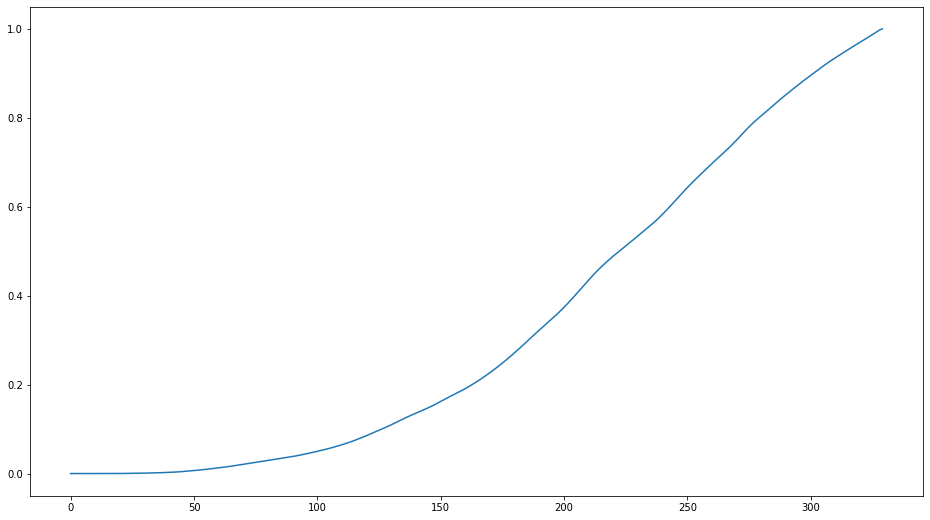

In [51]:
scaler = MinMaxScaler()
data = pd.read_csv("/content/drive/MyDrive/Project/world_filtered_data.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

total_vacc_percent = data.iloc[:,-1].values.reshape(-1,1)
total_vacc_percent = scaler.fit_transform(total_vacc_percent)

plt.figure(figsize=(16,9))
plt.plot(total_vacc_percent)
plt.show()

# Class Feature Engineering

In [14]:
class RnnFeatureEngineering:

  def __init__(self, seq_len):
      self.seq_len = seq_len


  def create_new_dataset(self, dataset):
    X = []
    y = []

    start = 0
    end = dataset.shape[0] - self.seq_len
  
    for i in range(start, end):
      sample = dataset[i : i+self.seq_len]
      label = dataset[i+self.seq_len]
      X.append(sample)
      y.append(label)
    return np.array(X) , np.array(y)


  def split_dataset(self, X, y, train_ratio=0.8):
    X_len = len(X)
    train_data_len = int(X_len * train_ratio)
    
    X_train = X[:train_data_len]
    y_train = y[:train_data_len]

    X_test = X[train_data_len:]
    y_test = y[train_data_len:]
    return X_train, X_test, y_train, y_test 

  def create_batch_dataset(self, X, y, batch_size = 64, data_type = 1):
    if data_type == 1: # get test batch data
      dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
      test_batch_data = dataset.batch(batch_size)
      return test_batch_data
    else: # get train batch data
      dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
      train_batch_data = dataset.cache().shuffle(500).batch(batch_size)
      return train_batch_data

# Model Training

In [25]:
class RnnModel:
  def __init__(self, file_path, X_test, y_test):
    self.file_path = file_path
    self.X_test = X_test
    self.y_test = y_test


  def ModelFlow(self, model,train_batch_dataset, test_batch_dataset):
    utils.plot_model(model)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(self.file_path,
                                                             monitor='loss',
                                                             save_best_only = True,
                                                             save_weights_only = True)
    
    model.compile(optimizer='adam', loss='mse')
    model_history = model.fit(train_batch_dataset,
                              epochs=40,
                              validation_data = test_batch_dataset,
                              callbacks=[checkpoint_callback])
    


    plt.figure(figsize=(16,8))
    plt.plot(model_history.history['loss'],label = 'train loss')
    plt.plot(model_history.history['val_loss'],label='validation loss')
    plt.title("LOSS")
    plt.ylabel("Loss")
    plt.xlabel('epochs')
    plt.legend(loc='best')
    plt.show()


    test_pred = model.predict(self.X_test, verbose=1)
    plt.figure(figsize=(16,8))
    plt.plot(self.y_test,label = 'True value')
    plt.plot(test_pred,label='Predicted Value')
    plt.title("True vs Pred")
    plt.legend(loc='best')
    plt.show()

    score_r2 = r2_score(self.y_test,test_pred)
    print("R2 score: ",score_r2)
    score_mae = mean_absolute_error(self.y_test,test_pred)
    print("Mean Absolute error: ",score_mae)
    score_rmse = math.sqrt(mean_squared_error(self.y_test,test_pred))
    print("Mean Absolute error: ",score_rmse)
    return model_history

# Single Variable Model

In [28]:
feature_eng = RnnFeatureEngineering(20)
X_single, y_single = feature_eng.create_new_dataset(total_vacc_percent)

X_train_single, X_test_single, y_train_single, y_test_single = feature_eng.split_dataset(X_single, y_single, train_ratio=0.8)

test_batch_single = feature_eng.create_batch_dataset(X_test_single, y_test_single, batch_size=128)

train_batch_single = feature_eng.create_batch_dataset(X_train_single, y_train_single, batch_size=128,data_type=2)

In [19]:
single_model = Sequential([
layers.LSTM(units=280,input_shape=(20,1)),
layers.Dense(1)
])

Epoch 1/40
2/2 [==============================] - 7s 1s/step - loss: 0.0765 - val_loss: 0.1434
Epoch 2/40
2/2 [==============================] - 1s 288ms/step - loss: 0.0106 - val_loss: 0.0856
Epoch 3/40
2/2 [==============================] - 0s 275ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 4/40
2/2 [==============================] - 1s 298ms/step - loss: 0.0024 - val_loss: 0.0212
Epoch 5/40
2/2 [==============================] - 0s 277ms/step - loss: 0.0042 - val_loss: 0.0524
Epoch 6/40
2/2 [==============================] - 1s 294ms/step - loss: 0.0071 - val_loss: 0.0448
Epoch 7/40
2/2 [==============================] - 1s 273ms/step - loss: 0.0052 - val_loss: 0.0164
Epoch 8/40
2/2 [==============================] - 1s 314ms/step - loss: 0.0017 - val_loss: 1.8810e-05
Epoch 9/40
2/2 [==============================] - 1s 276ms/step - loss: 6.3393e-04 - val_loss: 0.0140
Epoch 10/40
2/2 [==============================] - 1s 313ms/step - loss: 0.0023 - val_loss: 0.0145
Epoch 11/40
2/

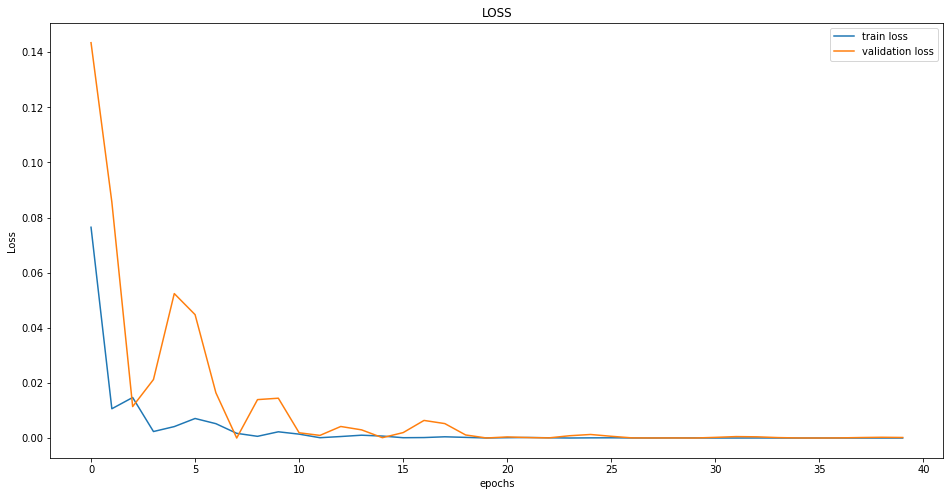

2/2 [==============================] - 1s 44ms/step


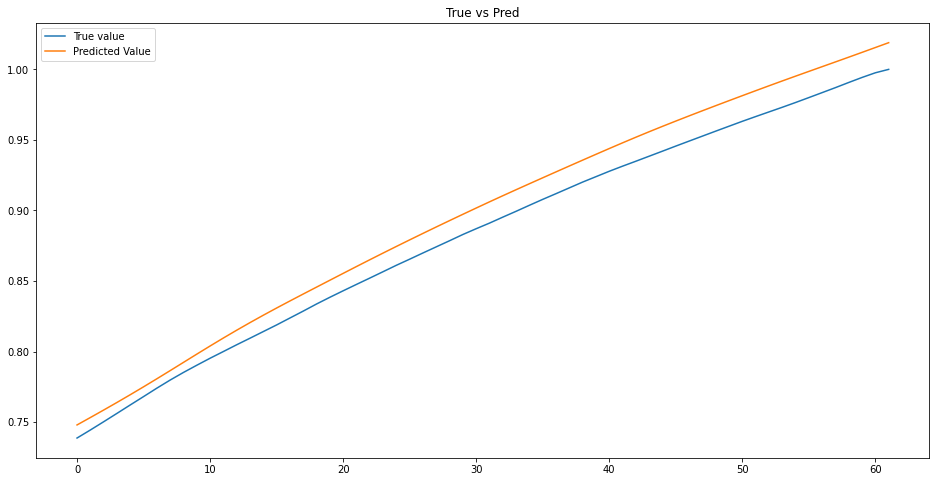

R2 score:  0.9633347357663411
Mean Absolute error:  0.014037875319230456
Mean Absolute error:  0.014533406997642686


In [26]:
single_file_path = "best_checkpoint_single.hdf5"
RNN_Single = RnnModel(single_file_path, X_test_single, y_test_single)
single_history = RNN_Single.ModelFlow(single_model, train_batch_single, test_batch_single)

# Multiple Variable Model

In [35]:
mul_dataset = data.to_numpy()
percent_vacc = mul_dataset[:,-1].reshape(-1,1)
feature = mul_dataset[:,0:2]
# Obtain the final Scaled data
percent_vacc = scaler.fit_transform(percent_vacc)
feature = scaler.fit_transform(feature)

In [37]:
X1,fake1 = feature_eng.create_new_dataset(feature)
fake2,y1 = feature_eng.create_new_dataset(percent_vacc)


X1_train, X1_test, y1_train, y1_test = feature_eng.split_dataset(X1, y1, train_ratio=0.8)

test_batch_multi = feature_eng.create_batch_dataset(X1_test, y1_test, batch_size=128)

train_batch_multi = feature_eng.create_batch_dataset(X1_train, y1_train, batch_size=128,data_type=2)

In [34]:
multi_model = Sequential([
                          layers.LSTM(units=128,input_shape=(20,2) ,return_sequences=True),
                          layers.Dropout(0.4),
                          layers.LSTM(units=128, return_sequences=True),
                          layers.Dropout(0.4),
                          layers.LSTM(units=24),
                          layers.Dense(1)
                          ])

Epoch 1/40
2/2 [==============================] - 9s 1s/step - loss: 0.0676 - val_loss: 0.0707
Epoch 2/40
2/2 [==============================] - 0s 236ms/step - loss: 0.0180 - val_loss: 0.0234
Epoch 3/40
2/2 [==============================] - 0s 206ms/step - loss: 0.0145 - val_loss: 0.1119
Epoch 4/40
2/2 [==============================] - 0s 236ms/step - loss: 0.0062 - val_loss: 0.1914
Epoch 5/40
2/2 [==============================] - 0s 208ms/step - loss: 0.0124 - val_loss: 0.1725
Epoch 6/40
2/2 [==============================] - 0s 202ms/step - loss: 0.0088 - val_loss: 0.1037
Epoch 7/40
2/2 [==============================] - 0s 202ms/step - loss: 0.0034 - val_loss: 0.0376
Epoch 8/40
2/2 [==============================] - 0s 205ms/step - loss: 0.0030 - val_loss: 0.0113
Epoch 9/40
2/2 [==============================] - 0s 196ms/step - loss: 0.0048 - val_loss: 0.0117
Epoch 10/40
2/2 [==============================] - 0s 209ms/step - loss: 0.0027 - val_loss: 0.0266
Epoch 11/40
2/2 [=====

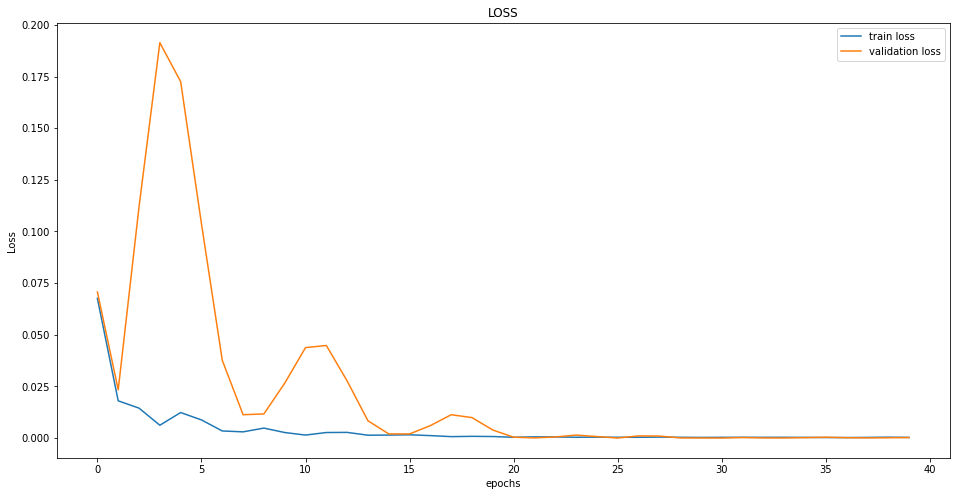

2/2 [==============================] - 1s 28ms/step


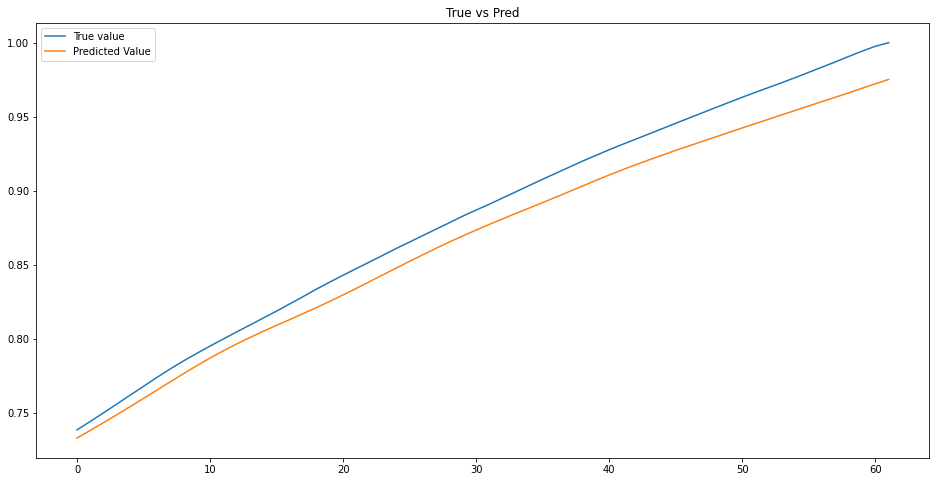

R2 score:  0.9566972662154536
Mean Absolute error:  0.014823922305788249
Mean Absolute error:  0.015794201842172888


In [38]:
multi_file_path = "best_checkpoint_multi.hdf5"
RNN_Multi = RnnModel(multi_file_path, X1_test, y1_test)
multi_history = RNN_Multi.ModelFlow(multi_model, train_batch_multi, test_batch_multi)

# Single Prediction

In [42]:
def predict_next(model, sample, epoch=20):
  tempt = list(sample[:,0])
  for i in range(epoch):
    sample = sample.reshape(1,20,1)
    pred = single_model.predict(sample)
    value = pred.tolist()[0][0]
    tempt.append(value)
    sample = np.array(tempt[i+1 : i+20+1])
  return tempt

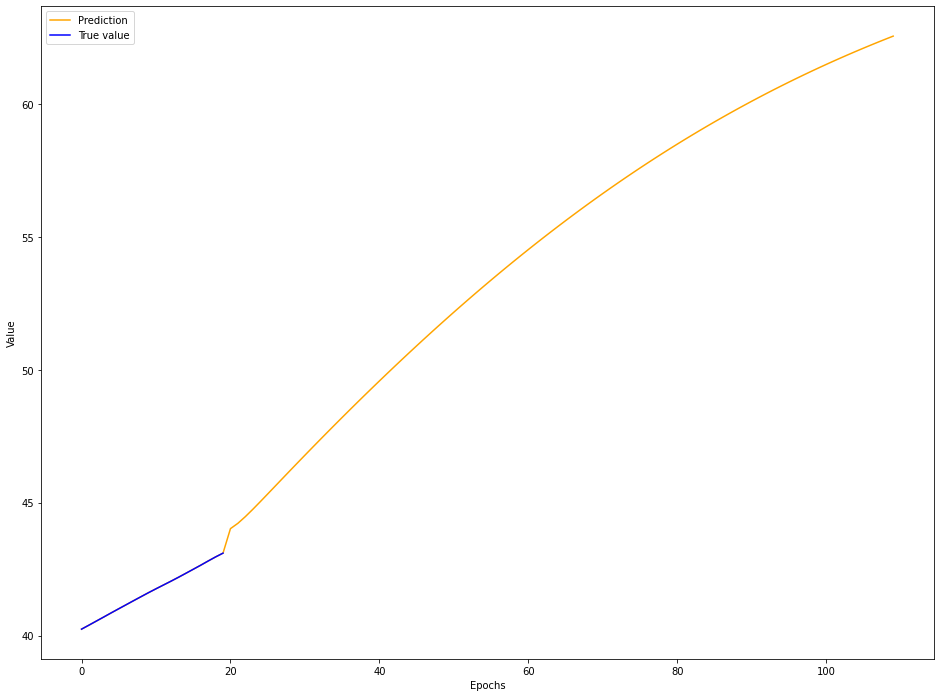

In [53]:
scaler = MinMaxScaler()
data = pd.read_csv("/content/drive/MyDrive/Project/world_filtered_data.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

total_vacc_percent = data.iloc[:,-1].values.reshape(-1,1)
total_vacc_percent = scaler.fit_transform(total_vacc_percent)

single_forpred_data = X_test_single[-1]
single_next = predict_next(single_model,single_forpred_data,epoch=90)
single_next = np.array(single_next).reshape(-1,1)
single_next = scaler.inverse_transform(single_next)

future_list = list(single_next[20:])
future_90 = pd.DataFrame(future_list,columns=['total_vacc'])

future_90.to_csv('future_90d_RNN.csv')

plt.figure(figsize=(16,12))
plt.plot(single_next, color='orange', label='Prediction')
plt.plot(single_next[:20], color='blue', label="True value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(loc='best')
plt.show()

# Interactive World Map

In [61]:
data_country = pd.read_csv("/content/drive/MyDrive/Project/world_countrywise_iso_codes.csv")
data_country['date'] = pd.to_datetime(data_country['date'])
data_country = data_country.drop(columns=['country'])

country_name = data_country['iso_code'].unique()
country_name_list = list(country_name) 
SEQ_LEN = 20

In [62]:
country_info = data_country[data_country['iso_code']=='AFG']
vacc_num = country_info['total_vaccinations'].to_numpy().reshape(-1,1)
sc_vacc_num = scaler.fit_transform(vacc_num)

In [63]:
country_data_for_pred = []

for name in country_name_list:
  country_info = data_country[data_country['iso_code']== name]
  vacc_num = country_info['total_vaccinations'].to_numpy().reshape(-1,1)
  sc_vacc_num = scaler.fit_transform(vacc_num)
  country_data_for_pred.append(sc_vacc_num[-SEQ_LEN:])
country_data_for_pred = np.array(country_data_for_pred).reshape(-1,SEQ_LEN,1)

In [64]:
predicted_vacc_country =[]
for i in range(0,len(country_data_for_pred)):
  country_sample = country_data_for_pred[i]
  next_vacc = predict_next(single_model,country_sample,epoch=90)
  next_vacc = np.array(next_vacc).reshape(-1,1)
  next_vacc = scaler.inverse_transform(next_vacc)
  predicted_vacc_country.append(next_vacc)

KeyboardInterrupt: ignored

In [ ]:
predicted_vacc_country = np.array(predicted_vacc_country).reshape(-1,110,1)

In [ ]:
final_iso_code_list = []
for i in range (0,len(country_name_list)):
  name = country_name_list[i]
  step_len = len(name)
  tempt_add = name * 90
  for index in range(0,len(tempt_add),step_len):
    name_add = tempt_add[index:index+step_len]
    final_iso_code_list.append(name_add)

In [ ]:
final_iso_code_array = np.array(final_iso_code_list).reshape(-1,1)

In [ ]:
country_stack = predicted_vacc_country[0][SEQ_LEN:]
for i in range(1,223):
  country_tempt = predicted_vacc_country[i]
  country_pred_value = country_tempt[SEQ_LEN:]
  country_stack = np.concatenate((country_stack,country_pred_value),axis=0)

By this step the accumulate predicted values of each country can be obtained, the rest is to create duplicated Time Series

In [ ]:
iso_value = np.concatenate((final_iso_code_array,country_stack),axis=1)

In [ ]:
time_series_frame = pd.date_range(start=datetime(2021,10,27),periods=90)
time_series_frame = pd.DataFrame(time_series_frame,columns=['date'])

In [ ]:
final_iso_vacc = pd.DataFrame(iso_value[0:90],columns=['iso_code','total_vacc'])
final_iso_vacc = pd.concat([time_series_frame,final_iso_vacc],axis=1)

In [ ]:
for i in range(90,20070,90):
  tempt_data = iso_value[i:i+90]
  tempt_frame = pd.DataFrame(tempt_data, columns=['iso_code','total_vacc'])
  tempt_frame = pd.concat([time_series_frame,tempt_frame],axis=1)
  final_iso_vacc = pd.concat([final_iso_vacc,tempt_frame])

In [ ]:
index = [*range(0,20070)]
final_iso_vacc['index'] = index
final_iso_vacc = final_iso_vacc.set_index('index')

In [ ]:
final_iso_vacc.date = final_iso_vacc.date.dt.strftime('%Y-%m-%d')

In [ ]:
final_iso_vacc.to_csv('future_vacc_num_in_90days.csv')

## Ready to Draw Interactive World Map

In [ ]:
import plotly.express as px

In [ ]:
final_vacc_num = final_iso_vacc['total_vacc']
max = final_vacc_num.max()
min = final_vacc_num.min()
max = int(float(max)) + 1 
min = int(float(min))

In [ ]:
fig = px.choropleth(final_iso_vacc,
                    locations = 'iso_code',
                    color = 'total_vacc',
                    animation_frame = 'date',
                    projection = 'natural earth',
                    color_continuous_scale = 'twilight',
                    range_color = [min,max]
                    )
fig.show()
fig.write_html("The next 90 days of World Vaccinations.html")